# Transforming Target
One of the common requirements is to transform the target variable itself. 
hcrystalball implements ``TargetTransformer`` transformer for such a cases, that internally scales input data and return un-scaled again.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=100, 
                    n_assortments=1, 
                    n_states=1, 
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

In [3]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [4]:
from hcrystalball.preprocessing import TargetTransformer

## With Wrapper

In [5]:
rf_model = get_sklearn_wrapper(RandomForestRegressor)
scaled = TargetTransformer(rf_model, StandardScaler())

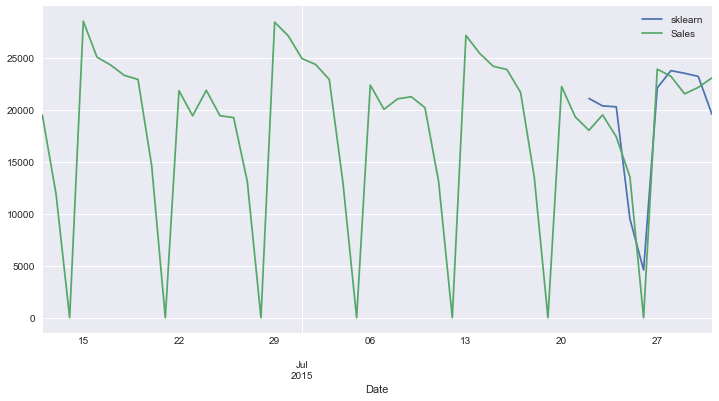

In [6]:
(scaled.fit(X[:-10], y[:-10])
       .predict(X[-10:])
       .merge(y, left_index=True, right_index=True, how='outer')
       .tail(50)
       .plot()
);

## With Pipeline

In [7]:
X['trend'] = np.arange(len(X))

In [8]:
# add standard scaler to the trend and let the date column pass in raw form
preprocessing = TSColumnTransformer(
    transformers=[        
        ('scaler', StandardScaler(), ['trend'])
    ])    
# define random forest model
rf_model = get_sklearn_wrapper(RandomForestRegressor)
# glue it together
sklearn_model_pipeline = Pipeline([
    ('preprocessing', preprocessing), 
    ('model', rf_model)
]) 

In [9]:
scaled_pipeline = TargetTransformer(sklearn_model_pipeline, StandardScaler())

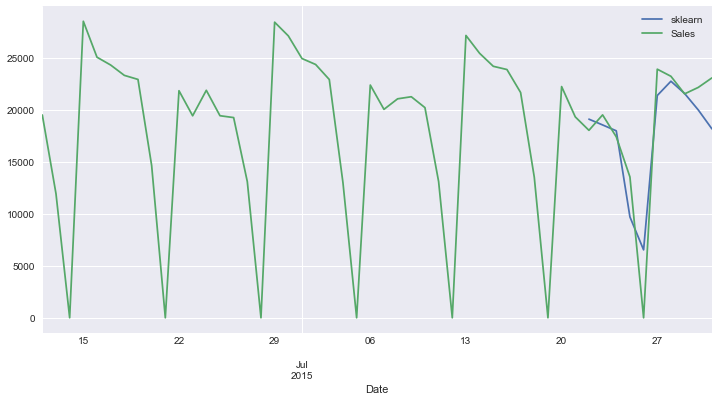

In [10]:
(scaled_pipeline.fit(X[:-10], y[:-10])
                .predict(X[-10:])
                .merge(y, left_index=True, right_index=True, how='outer')
                .tail(50)
                .plot()
);